In [2]:
import os
from pathlib import Path
import pandas as pd
import subprocess
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.agreement import mean_diff_plot
import statsmodels.api as sm

from mri_data import file_manager as fm
import helpers
import logging
from datetime import datetime

In [3]:
drive_root = fm.get_drive_root()
labelroot = drive_root / "srs-9/paper1/labels"
dataroot = drive_root / "3Tpioneer_bids"
df_root = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")

pd.options.mode.copy_on_write = True

In [4]:
def ms_wcontrast(df):
    return (df["dz_type2"] == "MS") & (df["flair_contrast"] == "WITH")

def ms_wocontrast(df):
    return (df["dz_type2"] == "MS") & (df["flair_contrast"] == "WITHOUT")

def all_rows(df):
    return (df['dz_type2'].isin(df['dz_type2'].unique()))

def w_contrast(df):
    return df["flair_contrast"] == "WITH"

def wo_contrast(df):
    return df["flair_contrast"] == "WITHOUT"

In [5]:
df_t1 = pd.read_csv(df_root / "t1_data_full.csv")
df_flair = pd.read_csv(df_root / "flair_data_full.csv")

df = df_t1[['subid', 'ms_type', 'flair_contrast', 'age', 'sex', 'tiv']]
df = helpers.set_dz_type2(df)
df = helpers.set_dz_type5(df)

df['cp_t1_vol'] = df_t1['choroid_volume']
df['cp_flair_vol'] = df_flair['choroid_volume']
df['pin_t1_vol'] = df_t1['pineal_volume']
df['pin_flair_vol'] = df_flair['pineal_volume']
df['pit_t1_vol'] = df_t1['pituitary_volume']
df['pit_flair_vol'] = df_flair['pituitary_volume']

df['cp_diff'] = df['cp_t1_vol'] - df['cp_flair_vol']
df['pin_diff'] = df['pin_t1_vol'] - df['pin_flair_vol']
df['pit_diff'] = df['pit_t1_vol'] - df['pit_flair_vol']

### Without Contrast

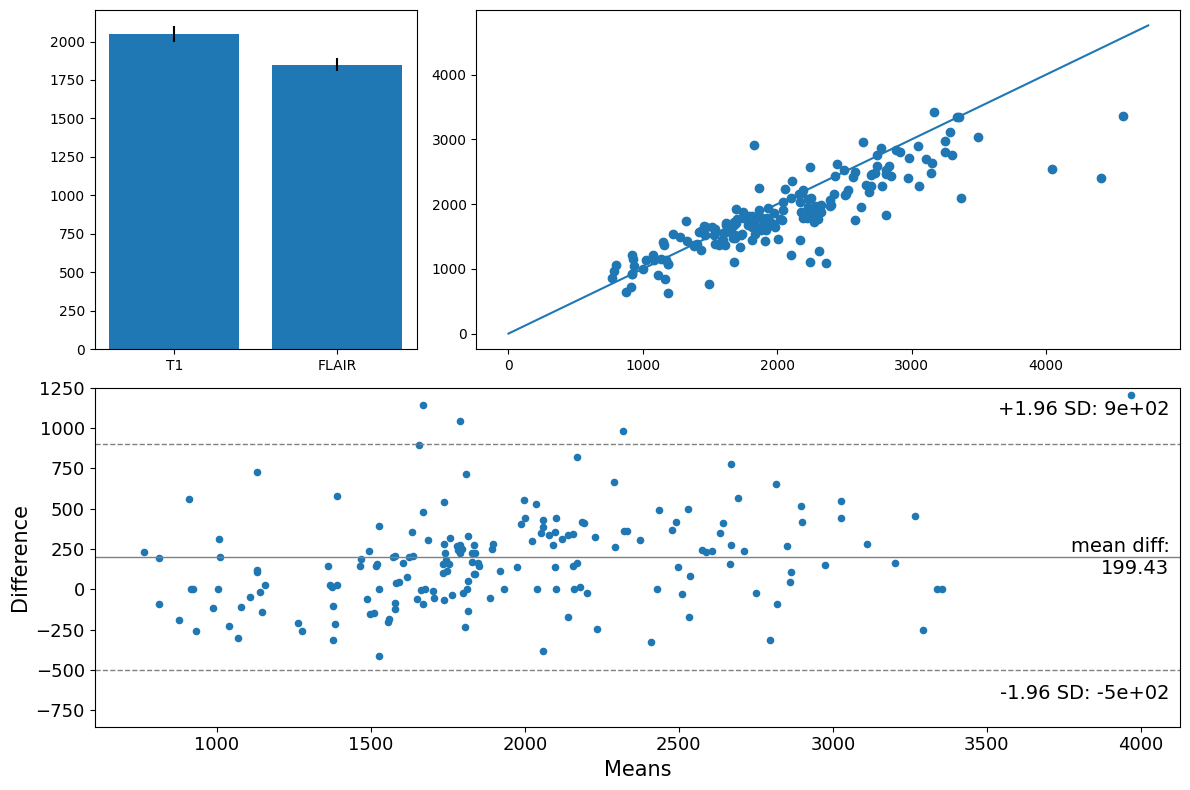

In [6]:
plt_data = df[wo_contrast(df)]
fig = plt.figure(figsize=[12, 8])
ax = fig.subplot_mosaic("""ABB
                        CCC""")

ax['A'].bar(["T1", "FLAIR"], [plt_data['cp_t1_vol'].mean(), plt_data['cp_flair_vol'].mean()],
            yerr=[plt_data['cp_t1_vol'].sem(), plt_data['cp_flair_vol'].sem()])

ax['B'].scatter(plt_data['cp_t1_vol'], plt_data['cp_flair_vol'])
lims = [ax['B'].get_xlim()[1], ax['B'].get_ylim()[1]]
ax['B'].plot([0, max(lims)], [0, max(lims)])

mean_diff_plot(plt_data["cp_t1_vol"], plt_data["cp_flair_vol"],
               ax=ax['C'])
plt.show()

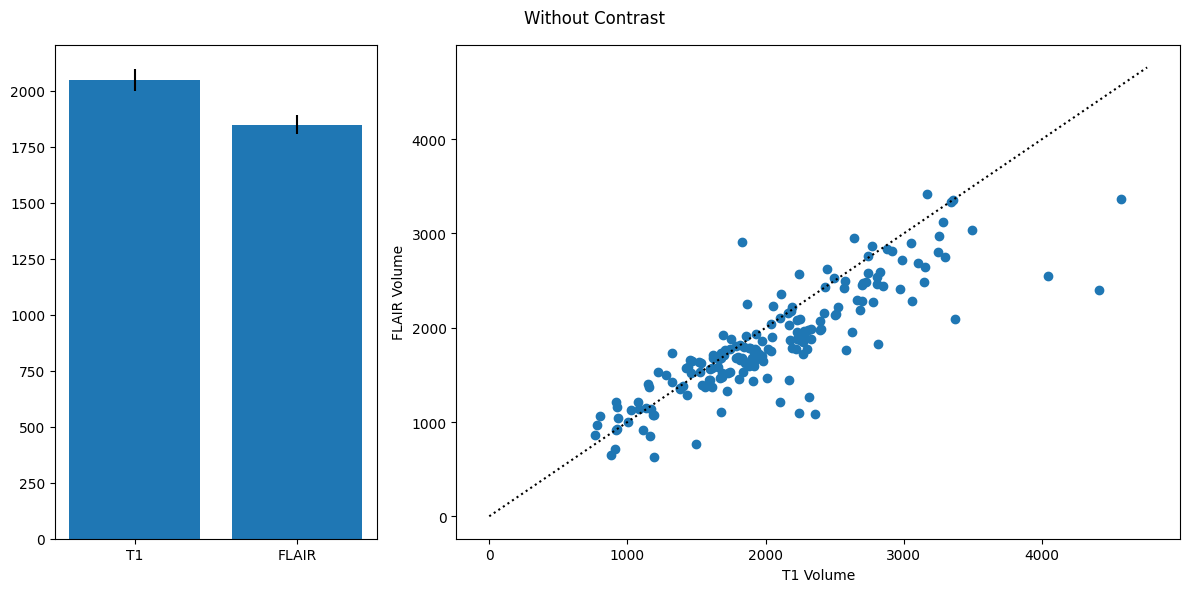

p=0.0026


In [7]:
plt_data = df[wo_contrast(df)]
fig = plt.figure(figsize=[12, 6])
fig.suptitle("Without Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['cp_t1_vol'].mean(), plt_data['cp_flair_vol'].mean()],
            yerr=[plt_data['cp_t1_vol'].sem(), plt_data['cp_flair_vol'].sem()])

ax["B"].set_ylabel("FLAIR Volume")
ax['B'].set_xlabel("T1 Volume")
ax['B'].scatter(plt_data['cp_t1_vol'], plt_data['cp_flair_vol'])
lims = [ax['B'].get_xlim()[1], ax['B'].get_ylim()[1]]
ax['B'].plot([0, max(lims)], [0, max(lims)], c=[0, 0, 0], linestyle=":")
plt.tight_layout()
plt.show()

stat, p = stats.ttest_ind(plt_data["cp_t1_vol"], plt_data["cp_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

p=0.0026


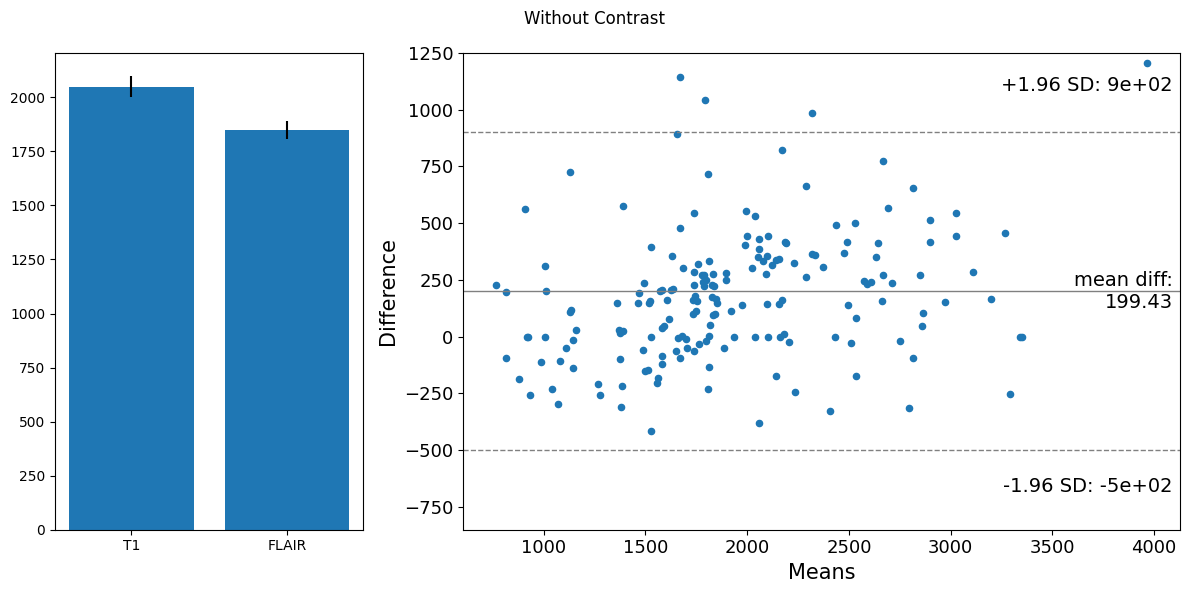

In [19]:
plt_data = df[wo_contrast(df)]
stat, p = stats.ttest_ind(plt_data["cp_t1_vol"], plt_data["cp_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

fig = plt.figure(figsize=[12, 6])
fig.suptitle("Without Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['cp_t1_vol'].mean(), plt_data['cp_flair_vol'].mean()],
            yerr=[plt_data['cp_t1_vol'].sem(), plt_data['cp_flair_vol'].sem()])

mean_diff_plot(plt_data["cp_t1_vol"], plt_data["cp_flair_vol"],
               ax=ax['B'])
plt.tight_layout()
plt.show()

p=0.34


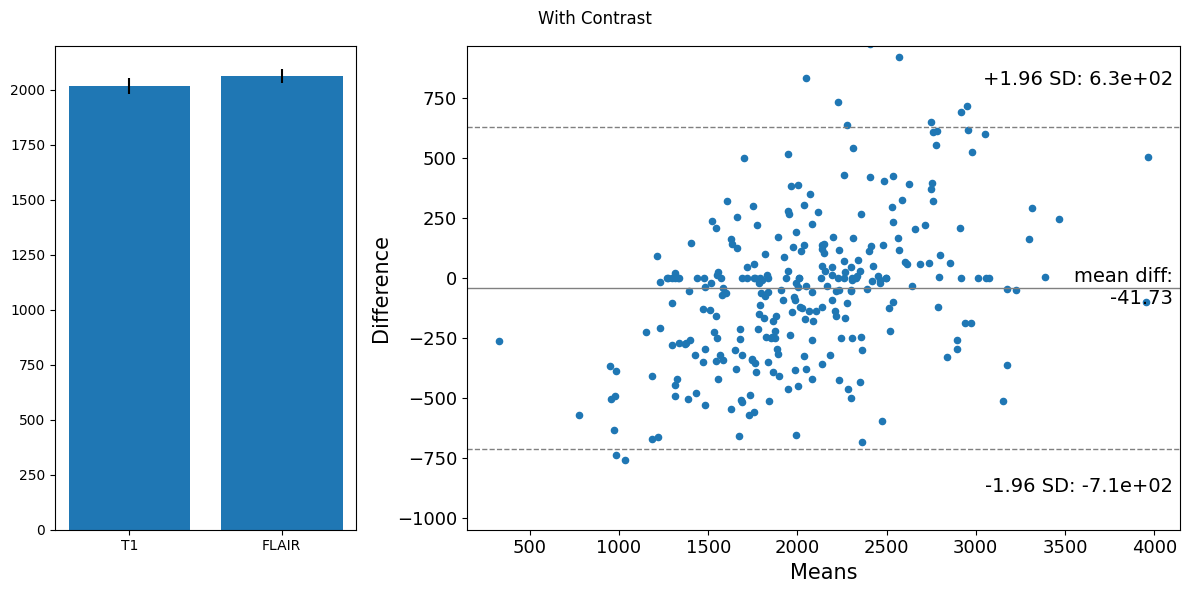

In [28]:
plt_data = df[w_contrast(df)]
stat, p = stats.ttest_ind(plt_data["cp_t1_vol"], plt_data["cp_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

fig = plt.figure(figsize=[12, 6])
fig.suptitle("With Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['cp_t1_vol'].mean(), plt_data['cp_flair_vol'].mean()],
            yerr=[plt_data['cp_t1_vol'].sem(), plt_data['cp_flair_vol'].sem()])

mean_diff_plot(plt_data["cp_t1_vol"], plt_data["cp_flair_vol"],
               ax=ax['B'])
plt.tight_layout()
plt.show()

In [11]:
model_data = df[df['flair_contrast'].isin(["WITHOUT"])]
# model_data = model_data[model_data['dz_type2'].isin(["MS", "!MS"])]

model = sm.OLS.from_formula("cp_diff ~ flair_contrast + age + sex + tiv + dz_type2", data=model_data)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                cp_diff   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     2.867
Date:                Tue, 04 Mar 2025   Prob (F-statistic):             0.0109
Time:                        09:15:37   Log-Likelihood:                -1334.3
No. Observations:                 184   AIC:                             2683.
Df Residuals:                     177   BIC:                             2705.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -315.2796    403.997     

In [15]:
model_data = df[df['flair_contrast'].isin(["WITHOUT", "WITH"])]
model_data = model_data[model_data['dz_type2'].isin(["MS", "!MS"])]

model = sm.OLS.from_formula("pin_diff ~ flair_contrast + age + sex + tiv + dz_type2", data=model_data)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               pin_diff   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.953
Date:                Tue, 04 Mar 2025   Prob (F-statistic):            0.00161
Time:                        09:15:37   Log-Likelihood:                -2840.7
No. Observations:                 463   AIC:                             5693.
Df Residuals:                     457   BIC:                             5718.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

p=0.0085


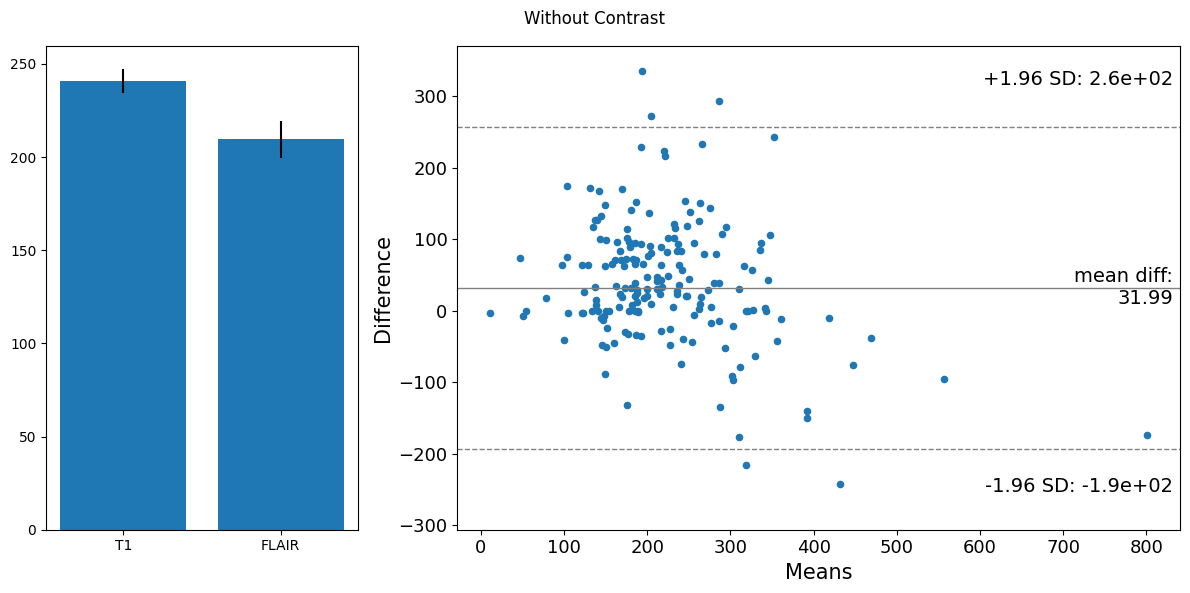

In [27]:
plt_data = df[wo_contrast(df)]
stat, p = stats.ttest_ind(plt_data["pin_t1_vol"], plt_data["pin_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

fig = plt.figure(figsize=[12, 6])
fig.suptitle("Without Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['pin_t1_vol'].mean(), plt_data['pin_flair_vol'].mean()],
            yerr=[plt_data['pin_t1_vol'].sem(), plt_data['pin_flair_vol'].sem()])

mean_diff_plot(plt_data["pin_t1_vol"], plt_data["pin_flair_vol"],
               ax=ax['B'])
plt.show()

p=0.35


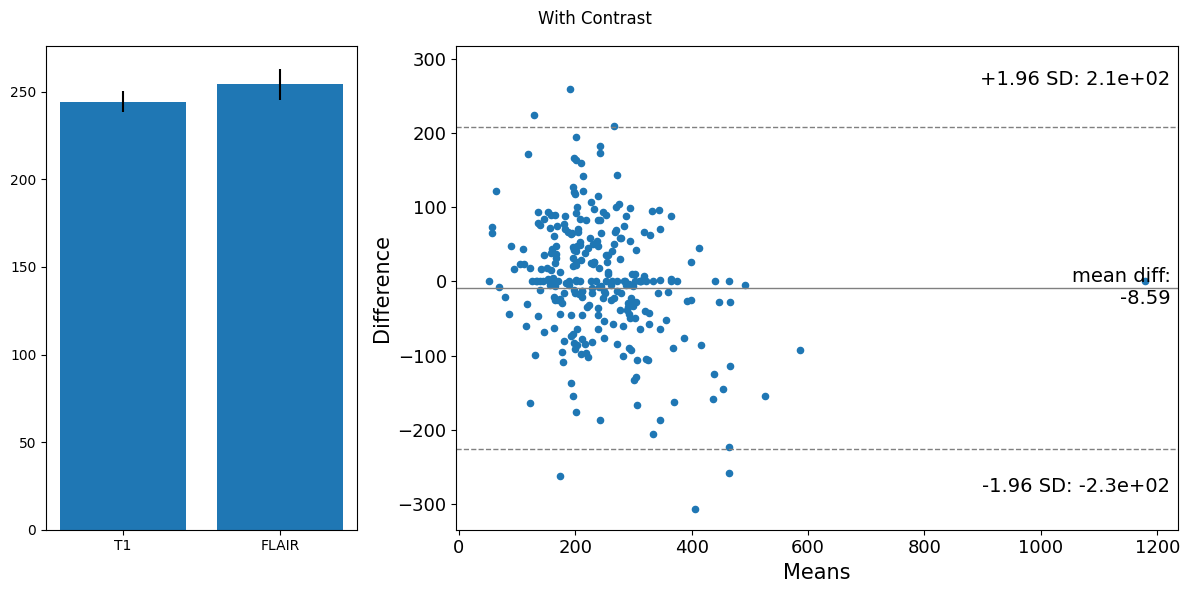

In [25]:
plt_data = df[w_contrast(df)]
stat, p = stats.ttest_ind(plt_data["pin_t1_vol"], plt_data["pin_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

fig = plt.figure(figsize=[12, 6])
fig.suptitle("With Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['pin_t1_vol'].mean(), plt_data['pin_flair_vol'].mean()],
            yerr=[plt_data['pin_t1_vol'].sem(), plt_data['pin_flair_vol'].sem()])

mean_diff_plot(plt_data["pin_t1_vol"], plt_data["pin_flair_vol"],
               ax=ax['B'])
plt.tight_layout()
plt.show()

p=3.9e-11


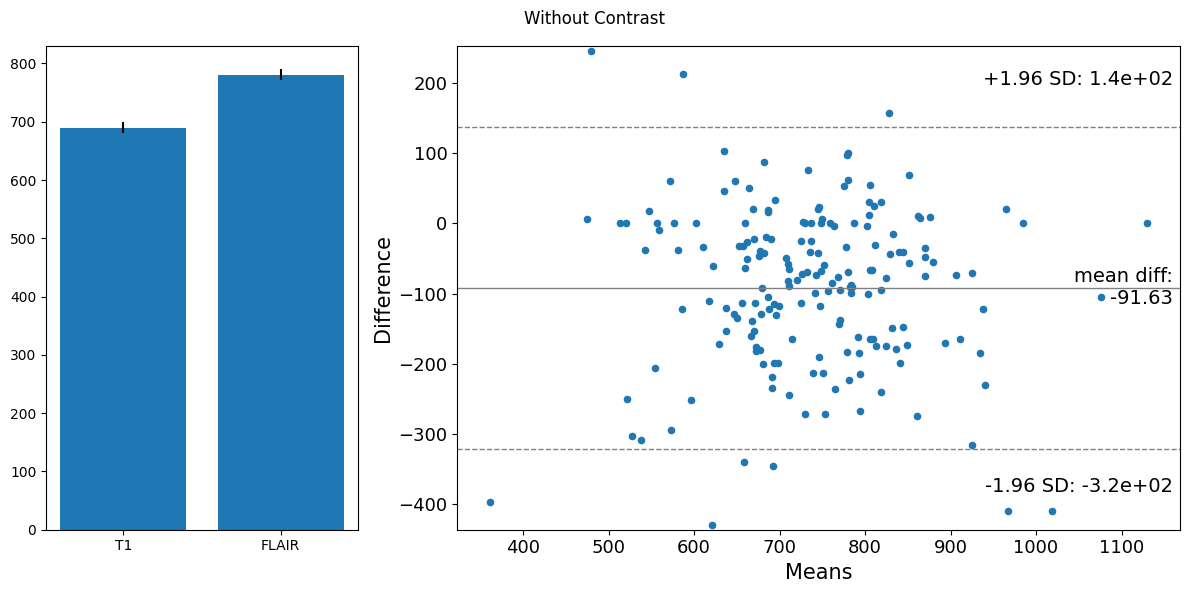

In [23]:
plt_data = df[wo_contrast(df)]
stat, p = stats.ttest_ind(plt_data["pit_t1_vol"], plt_data["pit_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

fig = plt.figure(figsize=[12, 6])
fig.suptitle("Without Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['pit_t1_vol'].mean(), plt_data['pit_flair_vol'].mean()],
            yerr=[plt_data['pit_t1_vol'].sem(), plt_data['pit_flair_vol'].sem()])

mean_diff_plot(plt_data["pit_t1_vol"], plt_data["pit_flair_vol"],
               ax=ax['B'])
plt.tight_layout()
plt.show()

p=0.97


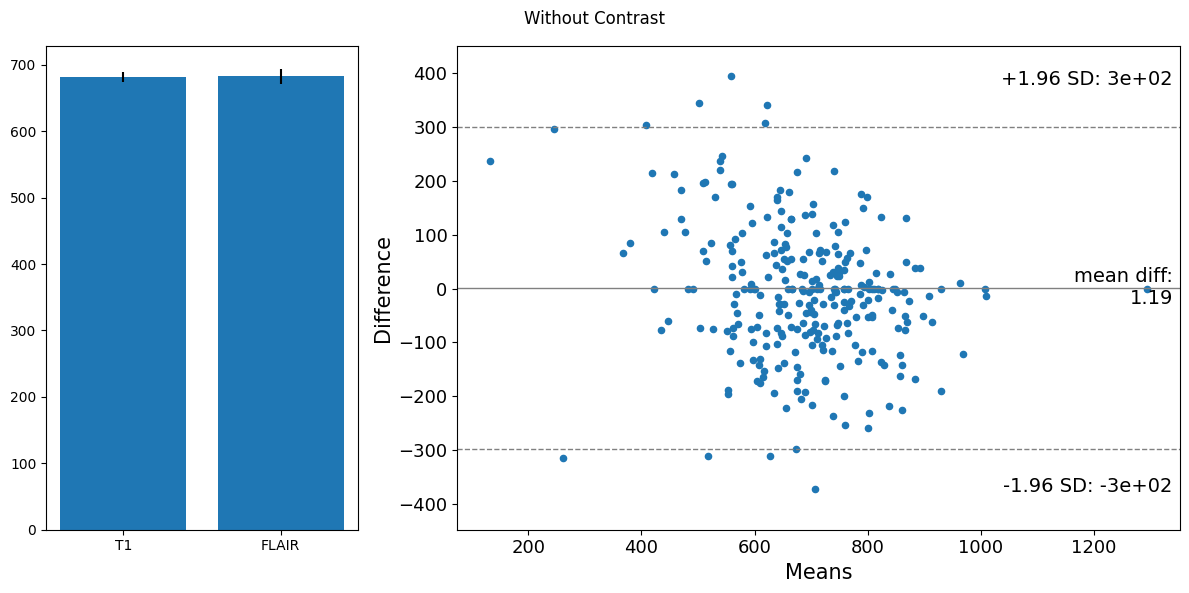

In [24]:
plt_data = df[w_contrast(df)]
stat, p = stats.ttest_ind(plt_data["pit_t1_vol"], plt_data["pit_flair_vol"],
                          nan_policy="omit", equal_var=False)
print("p={:0.2}".format(p))

fig = plt.figure(figsize=[12, 6])
fig.suptitle("Without Contrast")
ax = fig.subplot_mosaic("ABB")

ax['A'].bar(["T1", "FLAIR"], [plt_data['pit_t1_vol'].mean(), plt_data['pit_flair_vol'].mean()],
            yerr=[plt_data['pit_t1_vol'].sem(), plt_data['pit_flair_vol'].sem()])

mean_diff_plot(plt_data["pit_t1_vol"], plt_data["pit_flair_vol"],
               ax=ax['B'])
plt.tight_layout()
plt.show()

In [3]:
df = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/paper1/data0/t1_data_full.csv")

df.loc[df["sub-ses"].isna(), "sub-ses"] = ""
df.loc[df["label_folder"].isna(), "label_folder"] = ""
df.loc[df["label"].isna(), "label"] = ""

has_labelfile = []
for i, row in df.iterrows():
    file = labelroot / row["sub-ses"] / "t1_flair_diff-choroid-std.nii.gz"
    if file.exists():
        has_labelfile.append(i)

w_contrast = df[(df.index.isin(has_labelfile)) & (df["flair_contrast"] == "WITH")]
wo_contrast = df[(df.index.isin(has_labelfile)) & (df["flair_contrast"] == "WITHOUT")]